In [22]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import json
import sys

sys.path.insert(1, '../')
from MasterPlot_Functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'

In [5]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present'].copy()
future=df_long[df_long['Climate']=='Future'].copy()

In [13]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")

In [14]:
df_changes_noNan = df_changes_all.dropna()

## Testing statistical significance between distributions of D50 in the present and future
### Is there a statistically significant difference between the distribution of values across all events and all gauges, and all EMs?

In [8]:
# Perform KS test
ks_stat, p_value = ks_2samp(present['D50_new'], future['D50_new'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.006697886131800002
P-value: 9.536354192233076e-21
The distributions are significantly different.


### Is there a statistically significant difference between the events at each gauge (for a particular duration) between present and future?

In [7]:
dur=24
present_6h = present[present['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(dur) in x or x == str(dur))]
future_6h = future[future['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(dur) in x or x == str(dur))]

In [9]:
sig_diff = 0
non_sig_diff = 0

diff = []

for gauge_num in range(0,1294):
    if gauge_num not in [444,827,888]:
        this_g_present = present_6h[present_6h['gauge_num'] == gauge_num]
        this_g_future = future_6h[future_6h['gauge_num'] == gauge_num]

        # Perform KS test
        ks_stat, p_value = ks_2samp(this_g_present['D50_new'], this_g_future['D50_new'])

    #     print(f"KS Statistic: {ks_stat}")
    #     print(f"P-value: {p_value}")

        if p_value < 0.05:
            # print(gauge_num, "The distributions are significantly different.")
            # print('')
            sig_diff = sig_diff +1
            diff.append(1)
        else:
            non_sig_diff = non_sig_diff +1
            diff.append(0) 
    #         print(gauge_num, "The distributions are not significantly different.")

print(sig_diff)
print(non_sig_diff)

59
1232


### Is there a statistically signfiicant difference between the mean values at each gauge?

In [15]:
# Assuming you have columns for present and future D50 values
present_D50 = df_changes_noNan['D50_mean_present']  # Column with present D50 values
future_D50 = df_changes_noNan['D50_mean_future']  # Column with future D50 values

# Perform a paired t-test to assess if the change is significant
t_stat, p_value = stats.ttest_rel(present_D50, future_D50)
t_stat, p_value

(-8.460680194817018, 7.115425472139616e-17)

In [18]:
# Perform KS test
ks_stat, p_value = ks_2samp(df_changes_noNan['D50_mean_present'], df_changes_noNan['D50_mean_future'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.11773818745158791
P-value: 3.2642278070130653e-08
The distributions are significantly different.


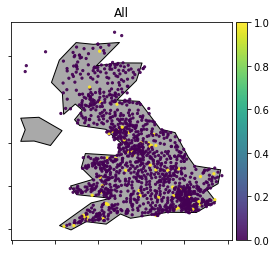

In [44]:
fig,ax=plt.subplots()
plot_values_on_map(ax, df_changes_all, 'All', tbo_vals, 
                   'sig', vmin=0, vmax=1,)

### Is there a statistically signfiicant difference between the mean values at each gauge? One value per gauge

In [17]:
def row_t_test(row):
    t_stat, p_val = stats.ttest_ind([row['D50_mean_present']], [row['D50_mean_future']], equal_var=False)
    return pd.Series({'t_stat': t_stat, 'p_val': p_val})

# Apply the t-test row-by-row
df_changes_noNan[['t_stat', 'p_val']] = df_changes_noNan.apply(row_t_test, axis=1)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## For comparison, do we also see a significant difference between ensemble members?

In [ ]:
bc005 = present[present['em']=='bc005']
bc006 = present[present['em']=='bc006']
bc007 = present[present['em']=='bc007']
bc009 = present[present['em']=='bc009']
bc010 = present[present['em']=='bc010']
bc011 = present[present['em']=='bc011']
bc013 = present[present['em']=='bc013']

### Check normality of the differences in mean D50 at each location 

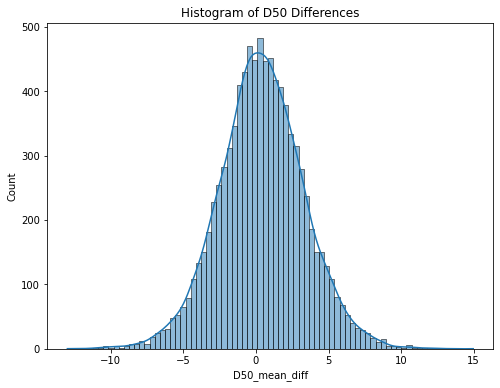

Shapiro-Wilk Test p-value: 1.0
Differences are normally distributed.


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [33]:
# 1. Checking for normality (visual inspection)
plt.figure(figsize=(8, 6))
sns.histplot(df_changes['D50_mean_diff'], kde=True)
plt.title('Histogram of D50 Differences')
plt.show()

# 2. Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(df_changes['D50_mean_diff'])
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

# If p-value < 0.05, the differences are likely not normally distributed
if shapiro_test.pvalue < 0.05:
    print("Differences are not normally distributed. Consider using a non-parametric test.")
else:
    print("Differences are normally distributed.")
